# Data Collection

Here we will be collecting the climate data for a city by various techniques from the website www.tutiempo.net. The Data consists of number of features as following :

- T	:   Average temperature (°C)
- TM:	Maximum temperature (°C)
- Tm:	Minimum temperature (°C)
- SLP:	Atmospheric pressure at sea level (hPa)
- H	:   Average relative humidity (%)
- PP:	Total precipitation of rain and/or melted snow (mm)
- VV:	Average visibility (Km)
- V :   Average wind speed (Km/h)
- VM:	Maximum sustained wind speed (Km/h)
- VG:	Maximum wind gust speed (Km/h)
- RA:	Indicates if there was rain or drizzle (In the monthly average, total days it rained)
- SN:	Snow indicator (In the monthly average, total days it snowed)
- TS:	Indicates if there was a storm (In the monthly average, total days with storm)
- FG:	Indicates if there was fog (On the monthly average, total days with fog)


## Important libraries required

In [1]:
import os
import time
import requests
import sys
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import csv

### Here we are collecting the html files for New Delhi

In [2]:
# function to get the htmls for New Delhi from year 2015-2020 for all the months

def retrieve_html():
    for year in range(2015,2021):
        for month in range(1,13):
            if month < 10:
                url = 'https://www.tutiempo.net/clima/0{}-{}/ws-421820.html'.format(month, year)
            else:
                url = 'https://www.tutiempo.net/clima/{}-{}/ws-421820.html'.format(month, year)
        
            # requesting the url for data
            source_texts = requests.get(url)
        
            # encoding the data that we get from url 
            text_utf = source_texts.text.encode('utf=8')
        
            # checking if the data for a particular year is present or not
            if not os.path.exists("C:/DataScience/Notebook/Portfolio Projects/Air Quality Index ML and DL/Data/Html_Data/{}"
                                  .format(year)):
                # making a folder for that year if it is not present
                os.makedirs("C:/DataScience/Notebook/Portfolio Projects/Air Quality Index ML and DL/Data/Html_Data/{}"
                            .format(year))
            
            # creating a html file for a particular month of year and writing the data into it
            with open("C:/DataScience/Notebook/Portfolio Projects/Air Quality Index ML and DL/Data/Html_Data/{}/{}.html"
                      .format(year, month),"wb") as output:
                output.write(text_utf)
        
            sys.stdout.flush()

In [3]:
# main function for retriving html

if __name__ == "__main__":
    start_time = time.time()
    retrieve_html()
    stop_time = time.time()
    print("Time taken: {}".format(stop_time - start_time))

Time taken: 53.2115695476532


We have extracted the htmls for the data for all the months of years from 2015-2020. Now we require to get the Air Quality Index (AQI) Data which will be our dependent feature, that we will be getting from a third party api and download it on our systems.   

In [4]:
# sample data check for AQI

df_dependent = pd.read_csv(r'C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\AQI\aqi2020.csv')
df_dependent.head()

,Date,Time,PM2.5
0,01-01-2020,1:00 AM,235
1,01-01-2020,2:00 AM,228
2,01-01-2020,3:00 AM,260
3,01-01-2020,4:00 AM,268
4,01-01-2020,5:00 AM,234


Here it can be seen that we are having the AQI data for every hour of the day, but in the html files we have the data for each day so we need to preprocess the data and get average AQI for each day.

## Calculating Average AQI data 

In [5]:
# function to convert per hour AQI to Average AQI
# reading data in chunk of 24 to calculate average AQI for a day

def avg_data(year):
    temp_i = 0
    average = []
    for rows in pd.read_csv(r'C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\AQI\aqi{}.csv'.format(year), chunksize = 24):
        add_var = 0
        avg = 0.0
        data = []
        df = pd.DataFrame(data = rows)
        for index, row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if type(i) is float or type(i) is int:
                add_var += i
            elif type(i) is str:
                if i not in ('NoData','PwrFail','---','InVld'):
                    temp = float(i)
                    add_var += temp
        
        avg = add_var / 24
        temp_i += 1
        
        average.append(avg)
    return average

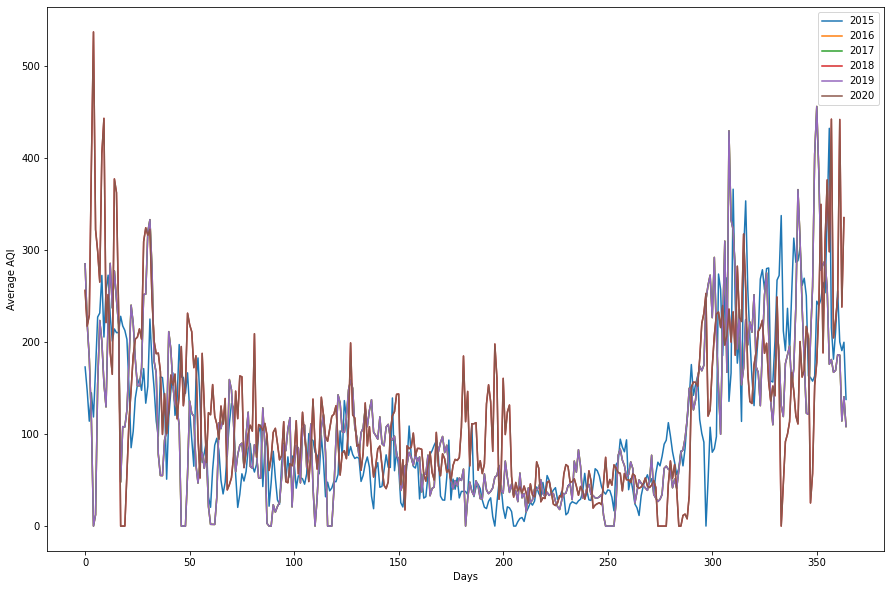

In [6]:
# viewing the average AQI data obtained
# main function for calculating Avg AQI

if __name__ == "__main__":
    plt.figure(figsize = (15,10))
    for i in range(2015,2021):
        plt.plot(avg_data(i),label = i)
        plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Average AQI')
    plt.show()

## Webscraping the data from html files

In [7]:
# function to perform webscrapping inorder to get data from html files

def met_data(month, year):
    file_html = open("C:/DataScience/Notebook/Portfolio Projects/Air Quality Index ML and DL/Data/Html_Data/{}/{}.html"
                     .format(year, month),'rb')
    plain_text = file_html.read()
    
    tempD = []
    finalD = []
    
    # extracting data from table
    
    soup = BeautifulSoup(plain_text, "lxml")
    for table in soup.findAll('table',{'class':'medias mensuales numspan'}):
        for tbody in table:
            for tr in tbody:
                a = tr.get_text()
                tempD.append(a)
                
    rows = len(tempD)/15
    
    for times in range(round(rows)):
        newtempD = []
        for i in range(15):
            newtempD.append(tempD[0])
            tempD.pop(0)
        finalD.append(newtempD)
    
    length = len(finalD)
    
    # removing the unwanted record 'Monthly Average Total'
    finalD.pop(length - 1)
    finalD.pop(0)
    
    # removing columns that are null [DAY, PP, VG, RA, SN, TS, FG]
    for a in range(len(finalD)):
        finalD[a].pop(6)
        finalD[a].pop(13)
        finalD[a].pop(12)
        finalD[a].pop(11)
        finalD[a].pop(10)
        finalD[a].pop(9)
        finalD[a].pop(0)
    
    return finalD

In [8]:
# function to combine data for years 2015-2020

def data_combine(year, cs):
    for a in pd.read_csv(r"C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data/real_" 
                         + str(year) + '.csv', chunksize=cs):
        df = pd.DataFrame(data=a)
        mylist = df.values.tolist()
    return mylist

In [9]:
# main function for combining html and AQI data to create a csv file for final data

if __name__ == "__main__":
    
    # creating a Real-Data directory
    if not os.path.exists(r"C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data"):
        os.makedirs(r"C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data")
     
    # creating csv file by combining html and AQI data for years 2015-2020
    for year in range(2015, 2021):
        final_data = []
        with open(r'C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data\real_' 
                  + str(year) + '.csv', 'w') as csvfile:
            wr = csv.writer(csvfile, dialect='excel')
            wr.writerow(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'])
        
        # getting data from each month html file for a year
        for month in range(1, 13):
            temp = met_data(month, year)
            final_data = final_data + temp
        
        # getting the Average AQI data
        pm = avg_data(year)
        
        if len(pm) == 364:
            pm.insert(364, '-')
        
        for i in range(len(final_data)-1):
            final_data[i].insert(8, pm[i])

        # dropping records where there is not data present
        with open(r'C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data\real_' 
                  + str(year) + '.csv', 'a') as csvfile:
            wr = csv.writer(csvfile, dialect='excel')
            for row in final_data:
                flag = 0
                for elem in row:
                    if elem == "" or elem == "-":
                        flag = 1
                if flag != 1:
                    wr.writerow(row)
    
    # combining the data for years 2015-2020                
    data_2015 = data_combine(2015, 600)
    data_2016 = data_combine(2016, 600)
    data_2017 = data_combine(2017, 600)
    data_2018 = data_combine(2018, 600)
    data_2019 = data_combine(2019, 600)
    data_2020 = data_combine(2020, 600)
     
    total = data_2015+data_2016+data_2017+data_2018+data_2019+data_2020
    
    # writing the final data in a csv file
    with open(r'C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data\Real_Combine.csv', 'w') as csvfile:
        wr = csv.writer(csvfile, dialect='excel')
        wr.writerow(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'])
        wr.writerows(total)
                
df = pd.read_csv(r'C:\DataScience\Notebook\Portfolio Projects\Air Quality Index ML and DL\Data\Real-Data\Real_Combine.csv')

In [10]:
# visualizing the final Data obtained

df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,14.9,21.6,8.8,1017.4,76.0,0.8,0.9,7.6,172.750000
1,14.7,21.6,10.2,1018.1,97.0,0.6,3.1,9.4,146.791667
2,15.0,16.8,13.6,1017.5,94.0,0.5,0.9,7.6,113.875000
3,9.8,17.6,6.4,1016.6,90.0,0.5,3.9,11.1,227.000000
4,10.1,14.5,7.2,1019.2,90.0,0.3,3.3,7.6,231.250000


We have successfully scrapped the data from html files and combined it with the Average AQI data inorder to create final data the we can use for creating a Machine Learning model.